In [1]:
library(ggplot2)
library(tidyr)
library(lubridate)
library(dplyr)
library(forcats)
library(slider)
library(cowplot)
source("../utils/helper_functions.r")

Warning message:
"package 'tidyr' was built under R version 4.2.2"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'forcats' was built under R version 4.2.1"
Warning message:
"package 'slider' was built under R version 4.2.1"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp


Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.7     ✔ purrr   0.3.4
✔ readr   2.1.2     ✔ stringr 1.5.0
Warning message:
"package 'readr'

In [2]:
osha = prep_osha_R("../01_clean-data/osha_clean_05.csv")

[1] 78710    28


In [3]:
cdc_hosp = read.csv("../00_data-raw/CDC/Weekly_Rates_of_Laboratory-Confirmed_COVID-19_Hospitalizations_from_the_COVID-NET_Surveillance_System_20250414.csv")
print(dim(cdc_hosp))

[1] 170290      9


In [4]:
cdc_hosp_filtered = cdc_hosp %>% 
mutate("X_WeekendDate" = date(as_datetime(X_WeekendDate))) %>%
filter(State == 'COVID-NET', 
       AgeCategory_Legend == "All", 
       Race_Label == 'All', 
       Sex_Label == 'All',
       X_WeekendDate < "2022-08-01") %>%
select(X_WeekendDate, WeeklyRate) %>% arrange(X_WeekendDate)

In [5]:
# Rolling averages
rolling = osha %>% 
    select(UPA.Receipt.Date, UPA.ID) %>% 
    group_by(UPA.Receipt.Date) %>% 
    summarize(n=n()) %>% 
    filter(n>0) %>%
    mutate(ma7 = slide_index_dbl(n, .i = UPA.Receipt.Date, .f = ~mean(.x), .before = days(6))) # 7-day lagged

rolling_ppe = osha %>%
    filter(isPPE) %>% # Include only PPE-related complaints
    select(UPA.Receipt.Date, UPA.ID) %>% 
    group_by(UPA.Receipt.Date) %>% 
    summarize(n=n()) %>% 
    filter(n>0) %>%
    mutate(ma7 = slide_index_dbl(n, .i = UPA.Receipt.Date, .f = ~mean(.x), .before = days(6))) # 7-day lagged

Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."
Warning message:
"The `trans` argument of `sec_axis()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead."


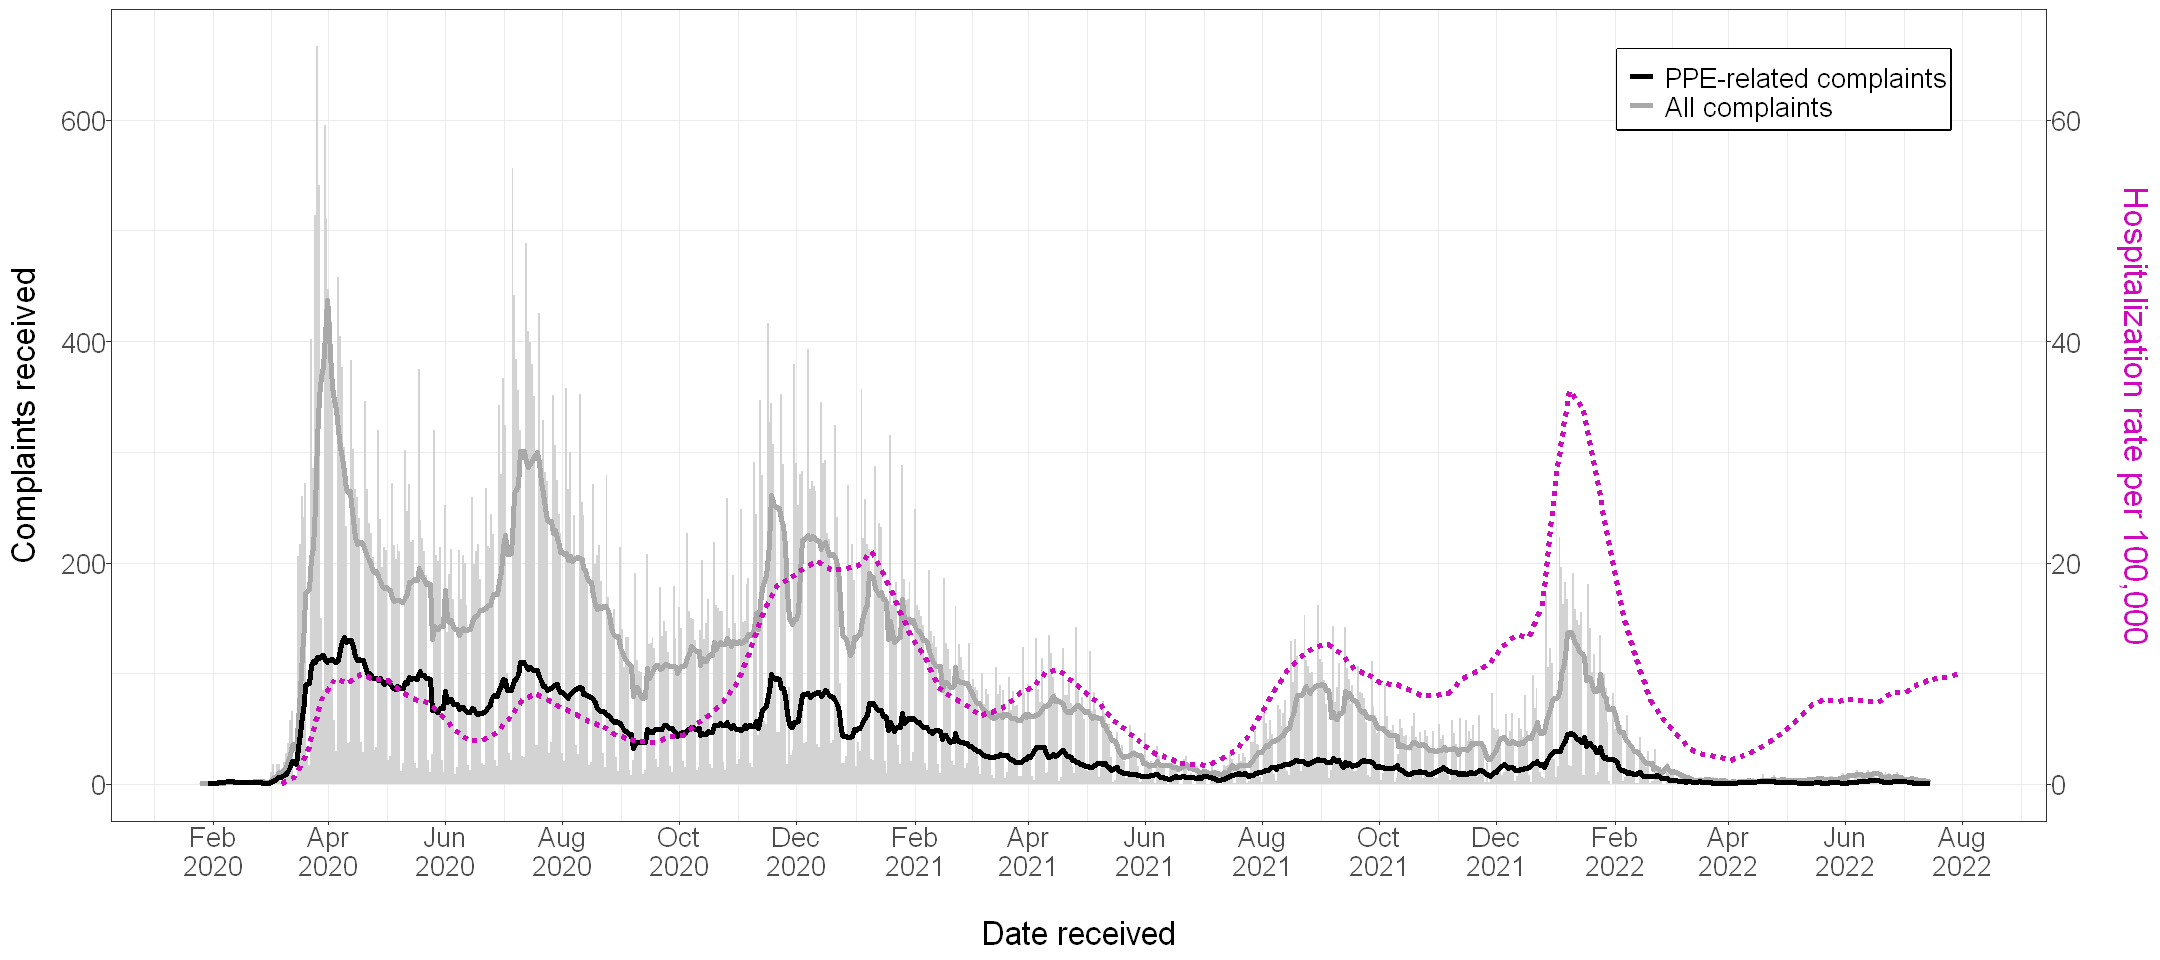

In [6]:
options(repr.plot.width=18, repr.plot.height=8)

# Plot complaint volume + rolling averages
complaint_volume = rolling %>% 
    ggplot() + 
    geom_col(mapping = aes(x=UPA.Receipt.Date, y=n), fill="lightgrey", width=1) +
    geom_line(data = rolling, mapping = aes(x=UPA.Receipt.Date, y=ma7, color="darkgrey"), linewidth=1.5) +
    geom_line(data = rolling_ppe, mapping = aes(x=UPA.Receipt.Date, y=ma7, color="black"), linewidth=1.5) +
    theme_bw() + 
    theme(text=element_text(size=20), 
          axis.text.x = element_text(margin = margin(b = 20)), 
          axis.text.y = element_text(margin = margin(l = 10)), 
          axis.text.y.right = element_text(margin = margin(r = 20)),
          axis.title.y.right = element_text(color = palette()[6]),
          plot.caption = element_text(size=10)
          ) +
    xlab("Date received") +
    ylab("") +
    scale_x_date(date_breaks = "2 month", date_labels = "%b\n%Y") +
    scale_color_manual(name = "", labels = c("PPE-related complaints", "All complaints"), values = c("darkgrey" = "darkgrey", "black" = "black")) + 
    theme(
        legend.position = c(.95, .95),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.box.background = element_rect(color="black", linewidth=1),
        legend.margin = margin(-18, 6, 6, 6)
    )

# Add hospitalizations
complaint_volume_ma7 = complaint_volume +
    geom_line(data=cdc_hosp_filtered, aes(x=X_WeekendDate, y=WeeklyRate*10), linewidth=1.5, lty="11", color = palette()[6]) +
    scale_y_continuous(
        name = "Complaints received",
        sec.axis = sec_axis(trans=~.*0.1, name="Hospitalization rate per 100,000")
    )

complaint_volume_ma7

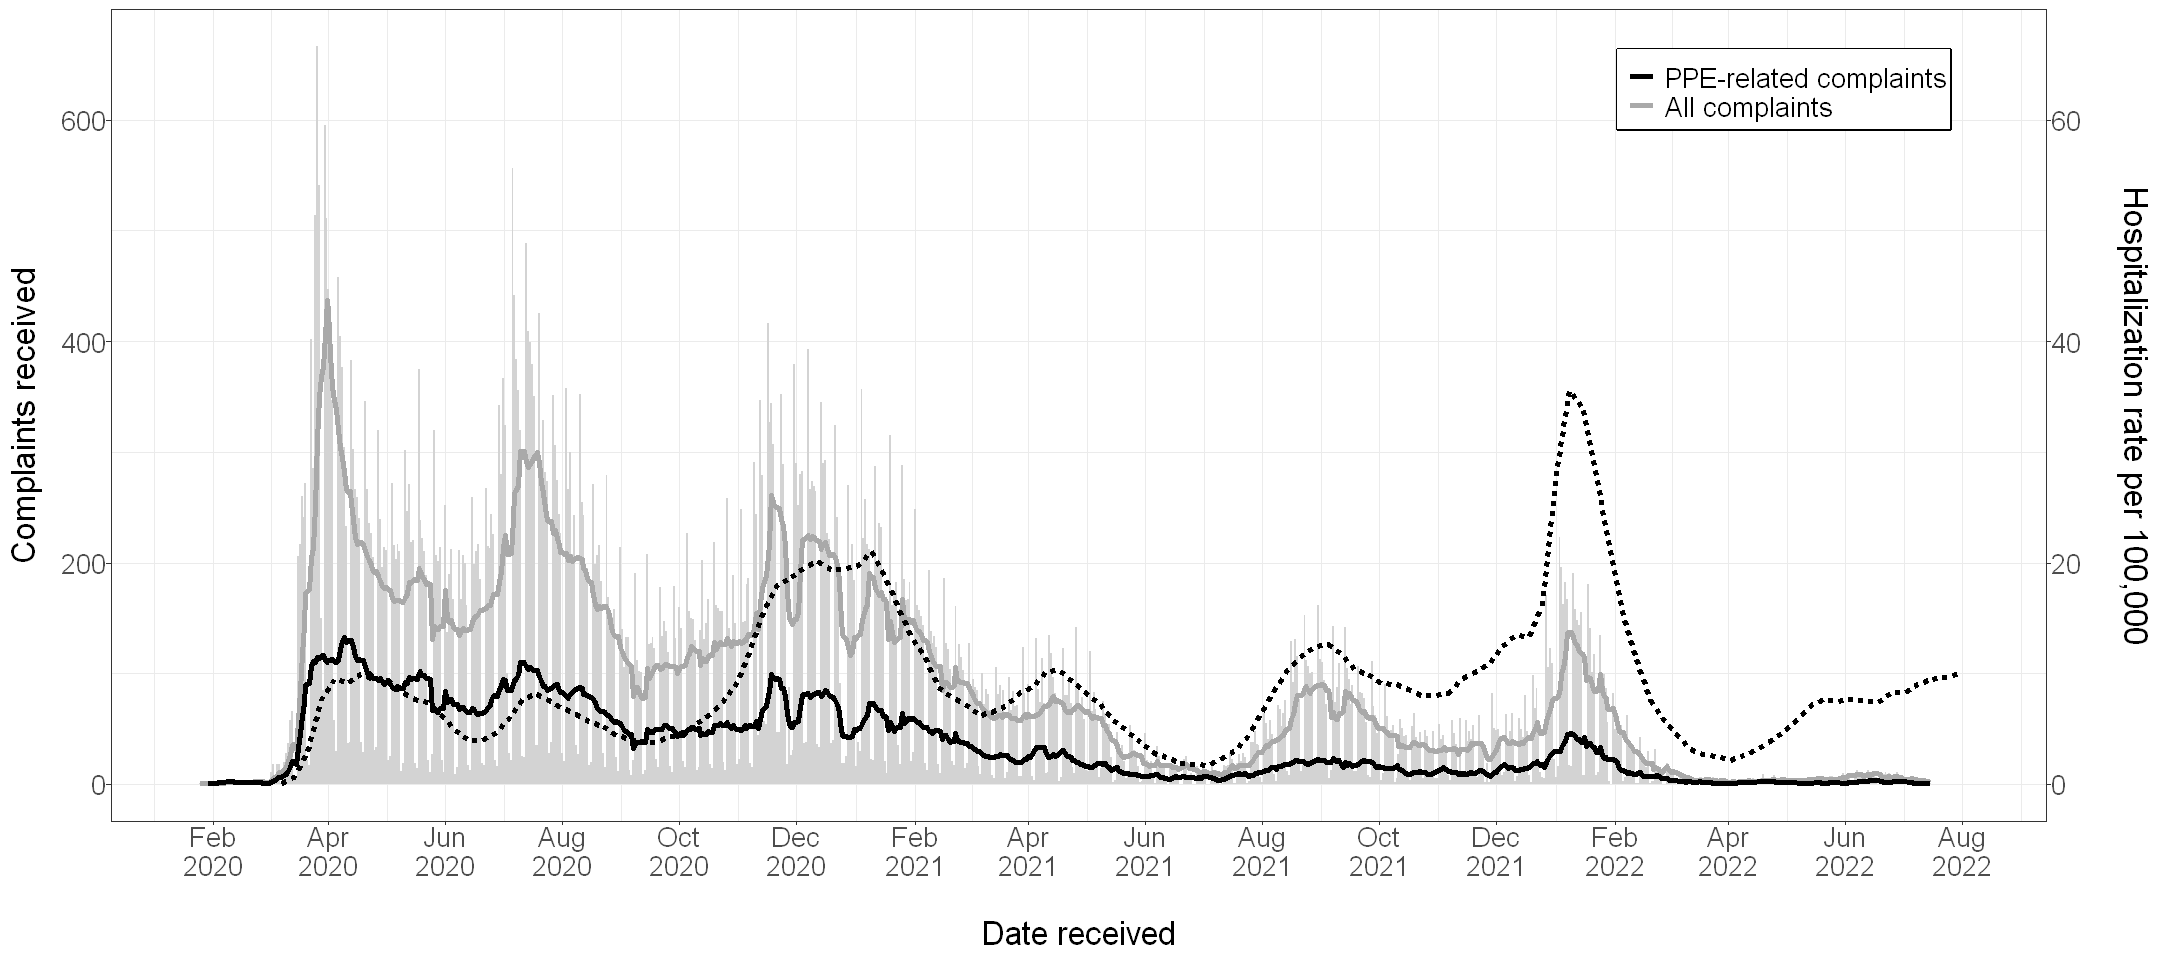

In [7]:
options(repr.plot.width=18, repr.plot.height=8)

# Plot complaint volume + rolling averages
complaint_volume = rolling %>% 
    ggplot() + 
    geom_col(mapping = aes(x=UPA.Receipt.Date, y=n), fill="lightgrey", width=1) +
    geom_line(data = rolling, mapping = aes(x=UPA.Receipt.Date, y=ma7, color="darkgrey"), linewidth=1.5) +
    geom_line(data = rolling_ppe, mapping = aes(x=UPA.Receipt.Date, y=ma7, color="black"), linewidth=1.5) +
    theme_bw() + 
    theme(text=element_text(size=20), 
          axis.text.x = element_text(margin = margin(b = 20)), 
          axis.text.y = element_text(margin = margin(l = 10)), 
          axis.text.y.right = element_text(margin = margin(r = 20)),
          axis.title.y.right = element_text(color="black"),
          plot.caption = element_text(size=10)
          ) +
    xlab("Date received") +
    ylab("") +
    scale_x_date(date_breaks = "2 month", date_labels = "%b\n%Y") +
    scale_color_manual(name = "", labels = c("PPE-related complaints", "All complaints"), values = c("darkgrey" = "darkgrey", "black" = "black")) + 
    theme(
        legend.position = c(.95, .95),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.box.background = element_rect(color="black", linewidth=1),
        legend.margin = margin(-18, 6, 6, 6)
    )

# Add hospitalizations
complaint_volume_ma7 = complaint_volume +
    geom_line(data=cdc_hosp_filtered, aes(x=X_WeekendDate, y=WeeklyRate*10), linewidth=1.5, lty="11", color = "black") +
    scale_y_continuous(
        name = "Complaints received",
        sec.axis = sec_axis(trans=~.*0.1, name="Hospitalization rate per 100,000")
    )

complaint_volume_ma7_grey = complaint_volume_ma7
complaint_volume_ma7_grey

In [8]:
preds = read.csv("./ppe_labeled.csv")
preds = mutate(preds, UPA.Receipt.Date = date(preds$UPA.Receipt.Date))

counts = preds %>% select(UPA.Receipt.Date) %>% group_by(UPA.Receipt.Date) %>% summarize(n=n())
counts = counts %>% filter(n>0) # Remove days with 0 counts. slide_index_dbl() will compute proper rolling averages by day.

In [9]:
# Rolling averages by PPE concern
rolling_all = preds %>% select(UPA.Receipt.Date, Availability, NotWornE, EnforceUse) %>% 
    pivot_longer(!UPA.Receipt.Date, names_to = "Concern", values_to = "isExpressed") %>% 
    group_by(UPA.Receipt.Date, Concern) %>%
    summarize(n=sum(isExpressed)) %>%
    filter(n>0) %>% # Remove days with 0 counts. slide_index_dbl() will compute proper rolling averages by day.
    group_by(Concern) %>%
    mutate(
        ma7 = slide_index_dbl(
            .x = n,
            .i = UPA.Receipt.Date, 
            .f = ~mean(.x), 
            .before = days(6)
        )
    )

`summarise()` has grouped output by 'UPA.Receipt.Date'. You can override using the `.groups` argument.


In [10]:
# Create a thinned dataframe for geom_point()
rolling_all_thinned = rolling_all %>% 
select(-c(n)) %>%
pivot_wider(names_from=Concern, values_from=ma7) %>%
filter(!is.na(Availability) & !is.na(EnforceUse) & !is.na(NotWornE)) %>%
slice(which(row_number() %% 10 == 1)) %>%
pivot_longer(!UPA.Receipt.Date, names_to = "Concern", values_to = "ma7")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


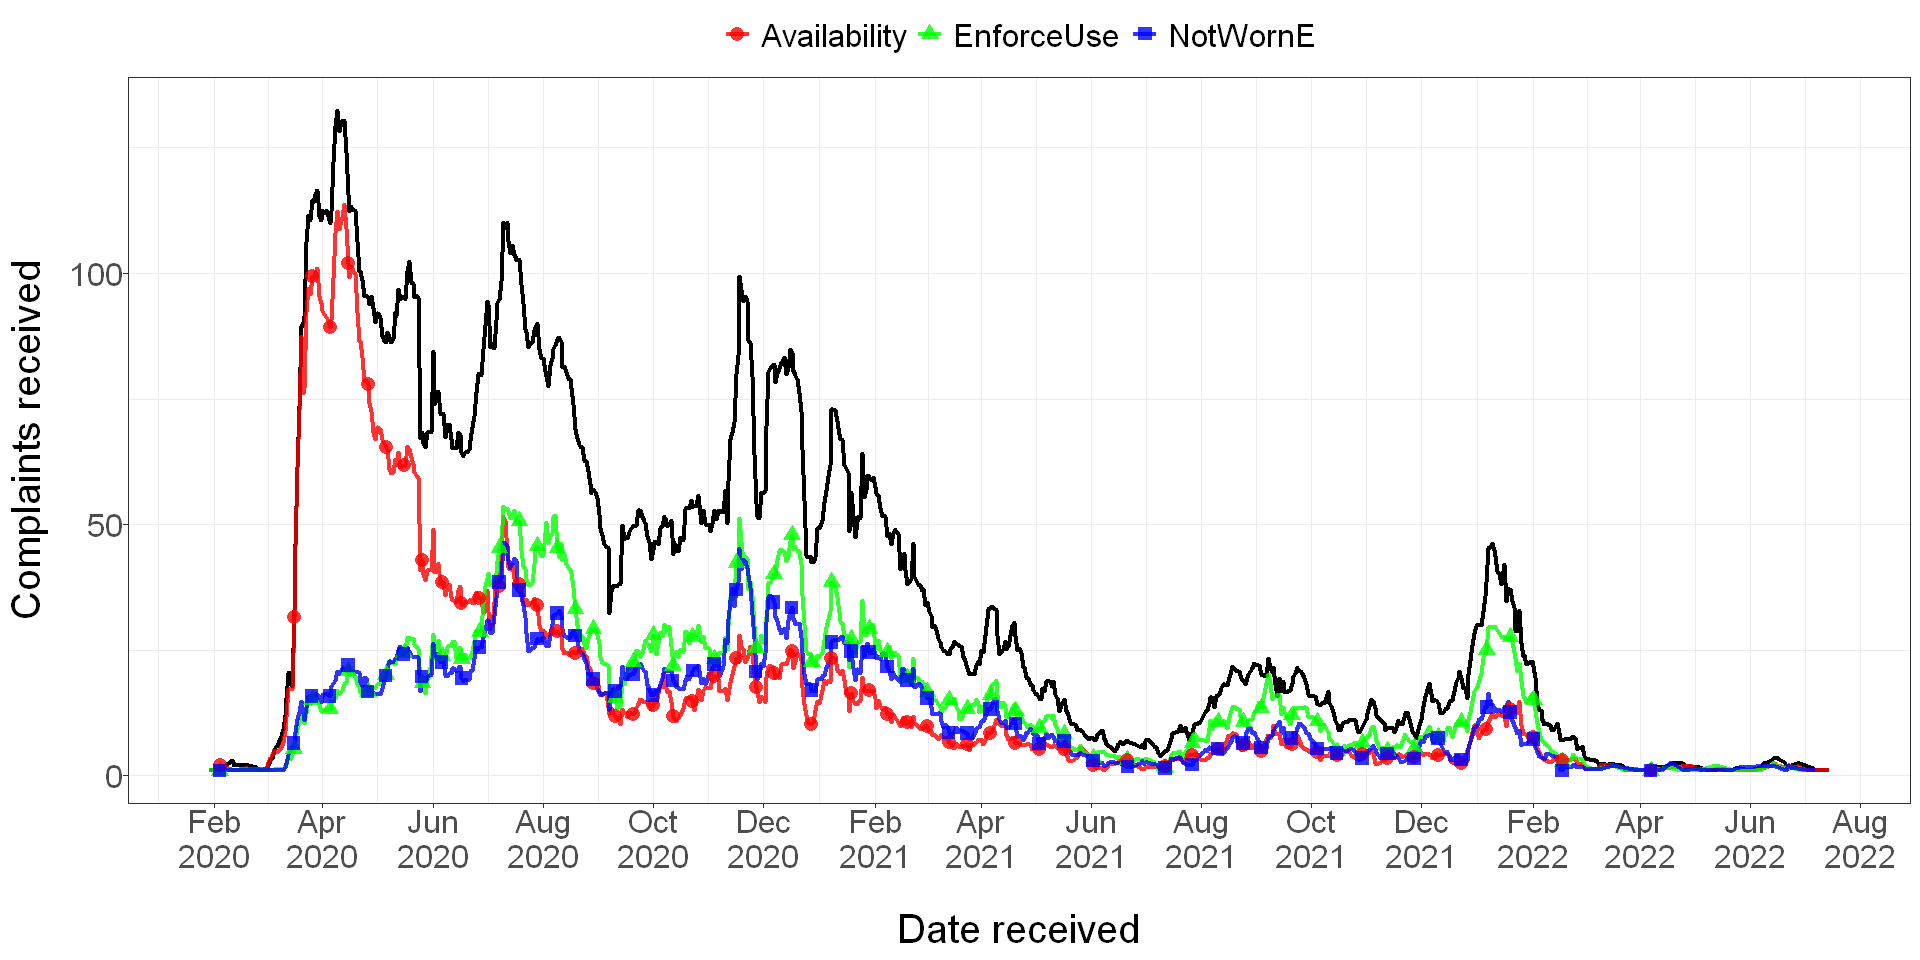

In [11]:
options(repr.plot.width=16, repr.plot.height=8)

complaint_volume_ma7_concerns = ggplot() + 
    geom_line(data = rolling_ppe, mapping = aes(x=UPA.Receipt.Date, y=ma7), color="black", size=1.35) +
    theme_bw() + 
    theme(text=element_text(size=20), 
          axis.text.x = element_text(margin = margin(b = 20)), 
          axis.text.y = element_text(margin = margin(l = 10)), 
          axis.text.y.right = element_text(margin = margin(r = 20)),
          axis.title.y.right = element_text(color = palette()[6]),
          plot.caption = element_text(size=10)
          ) +
    xlab("Date received") +
    ylab("Complaints received") +
    scale_x_date(date_breaks = "2 month", date_labels = "%b\n%Y") +
    geom_line(data = rolling_all, mapping = aes(x=UPA.Receipt.Date, y=ma7, color=Concern), linewidth=1.35, alpha=0.8) +
    geom_point(data = rolling_all_thinned, 
               mapping = aes(x=UPA.Receipt.Date, y=ma7, color=Concern, shape=Concern), 
               alpha = 0.8,
               size=3.5) +
    theme(text=element_text(size=24), 
          axis.text.x = element_text(margin = margin(b = 20)), 
          axis.text.y = element_text(margin = margin(l = 10)), 
          legend.position = "top", 
          legend.title = element_blank()) +
    scale_color_manual(values = c("red", "green", "blue"))
complaint_volume_ma7_concerns

In [12]:
# Select industries
select_industries = c("Health Care and Social Assistance", "Retail Trade", "Manufacturing", "Accommodation and Food Services")

# Rolling averages, by concern, by sector
rolling_ppe_concerns_sectors = preds %>%
    select(UPA.ID, NAICS.Title.2, UPA.Receipt.Date, Availability, NotWornE, EnforceUse) %>%
    pivot_longer(!c(UPA.ID, NAICS.Title.2, UPA.Receipt.Date), names_to = "Concern", values_to = "isExpressed") %>%
    filter(isExpressed!=0) %>% # filter out 0s
    mutate(UPA.ID=NULL) %>%
    group_by(UPA.Receipt.Date, NAICS.Title.2, Concern) %>%
    summarize(n=sum(isExpressed)) %>%
    # Computing rolling averages by sector
    filter(NAICS.Title.2 %in% select_industries) %>%
    arrange(Concern, NAICS.Title.2, UPA.Receipt.Date) %>%
    group_by(Concern, NAICS.Title.2) %>%
    mutate(
        ma7 = slide_index_dbl(
            .x = n,
            .i = UPA.Receipt.Date, 
            .f = ~mean(.x), 
            .before = days(6)
        )
    )

# Rolling averages for PPE-related complaint counts, by sector (replaces rolling_naics2)
rolling_ppe_sectors = osha %>% 
    filter(isPPE) %>%
    select(NAICS.Title.2, UPA.Receipt.Date, UPA.ID) %>% 
    group_by(NAICS.Title.2, UPA.Receipt.Date) %>% 
    summarize(n=n()) %>% 
    filter(n>0) %>%
    mutate(ma7 = slide_index_dbl(n, .i = UPA.Receipt.Date, .f = ~mean(.x), .before = days(6))) %>%
    filter(NAICS.Title.2 %in% select_industries)

`summarise()` has grouped output by 'UPA.Receipt.Date', 'NAICS.Title.2'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'NAICS.Title.2'. You can override using the `.groups` argument.


In [13]:
# Create a thinned dataframe for geom_point()
rolling_ppe_concerns_sectors_thinned = rolling_ppe_concerns_sectors %>% 
select(-c(n)) %>%
pivot_wider(names_from=Concern, values_from=ma7) %>%
filter(!is.na(Availability) & !is.na(EnforceUse) & !is.na(NotWornE)) %>%
slice(which(row_number() %% 10 == 5)) %>%
pivot_longer(!c(UPA.Receipt.Date, NAICS.Title.2), names_to = "Concern", values_to = "ma7")

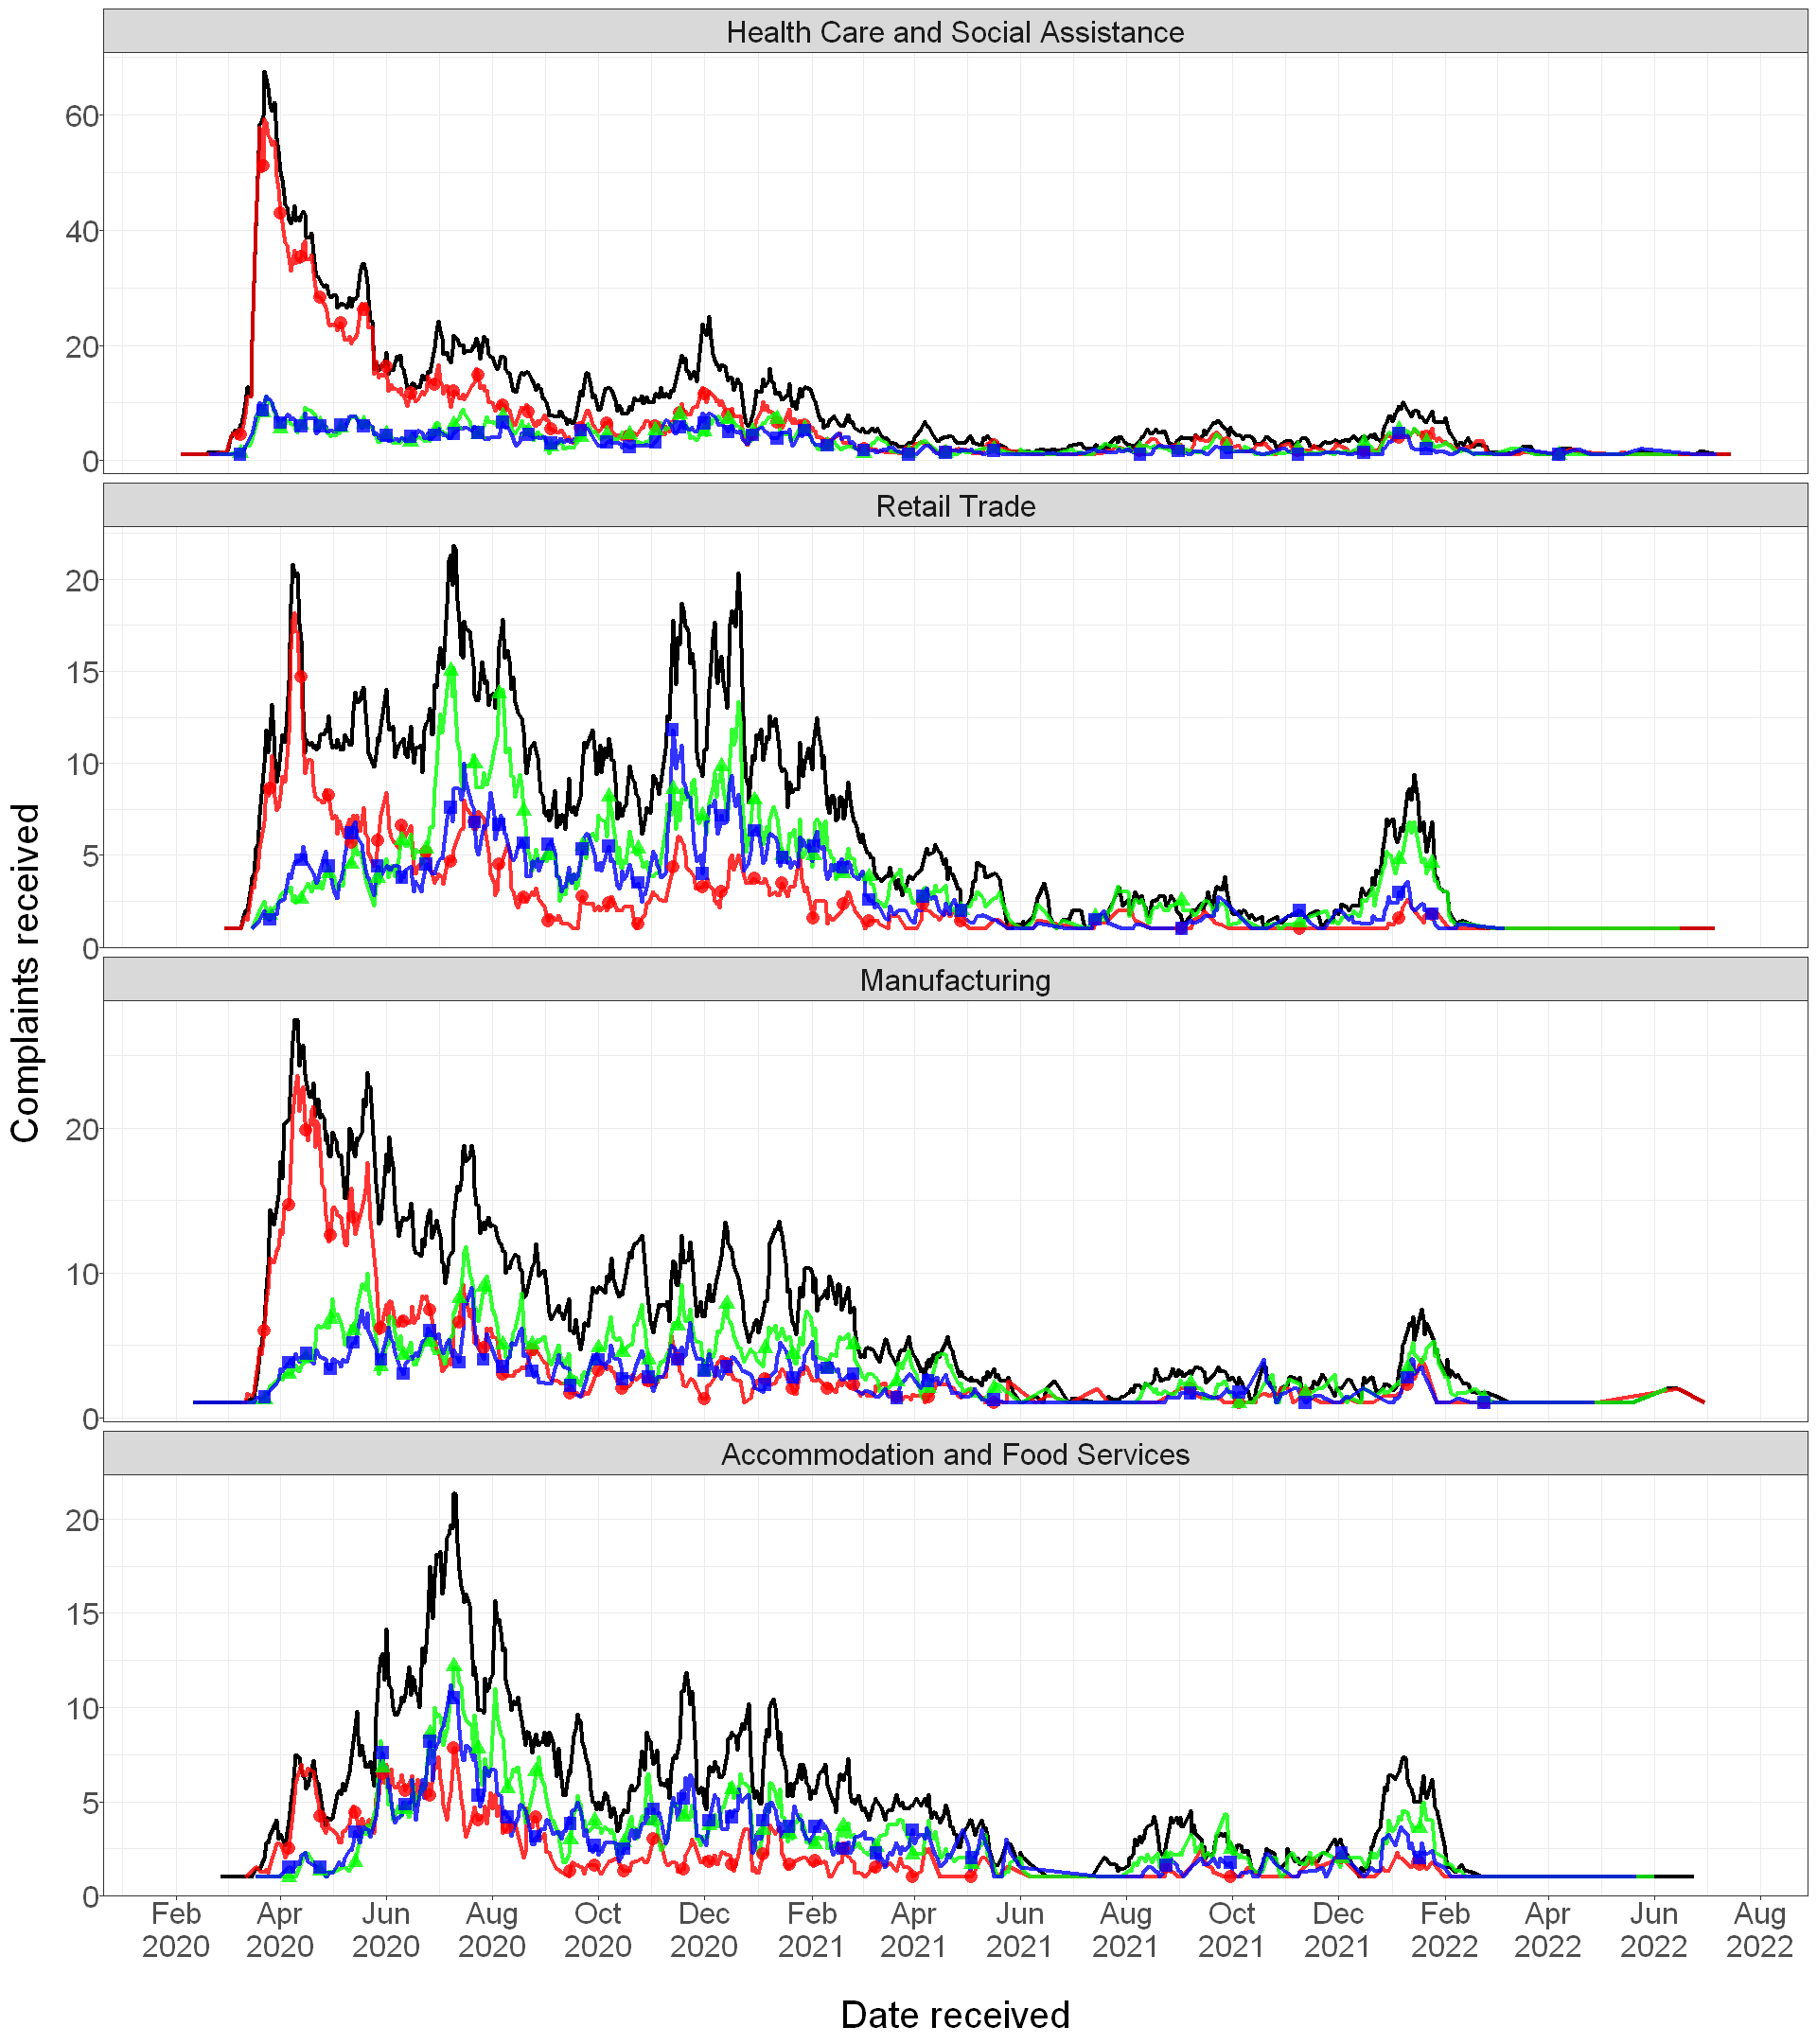

In [14]:
options(repr.plot.width=16, repr.plot.height=18)

complaint_volume_sectors = rolling_ppe_sectors %>%
    ggplot() +
    geom_line(data = rolling_ppe_sectors, mapping = aes(x = UPA.Receipt.Date, y= ma7), color = "black", linewidth = 1.35, alpha = 1) +
    facet_wrap(~forcats::fct_relevel(NAICS.Title.2, select_industries), ncol=1, scales = "free_y") +
    ylab("Complaints received") +
    xlab("Date received") +
    scale_x_date(date_breaks = "2 month", date_labels = "%b\n%Y") +
    theme_bw() +
    theme(text=element_text(size=24), axis.text.x = element_text(margin = margin(b = 20)), axis.text.y = element_text(margin = margin(l = 10)), legend.position = "top", legend.title = element_blank())


complaint_volume_sectors_concerns = complaint_volume_sectors +
    geom_line(data = rolling_ppe_concerns_sectors, mapping = aes(x = UPA.Receipt.Date, y = ma7, color = Concern), linewidth = 1.35, alpha=0.8) +
    scale_color_manual(values = c("red", "green", "blue")) +
    guides(color = "none", shape = "none") +
    geom_point(data = rolling_ppe_concerns_sectors_thinned, 
               mapping = aes(x=UPA.Receipt.Date, y=ma7, color=Concern, shape=Concern), 
               alpha = 0.8,
               size=3.5)

complaint_volume_sectors_concerns

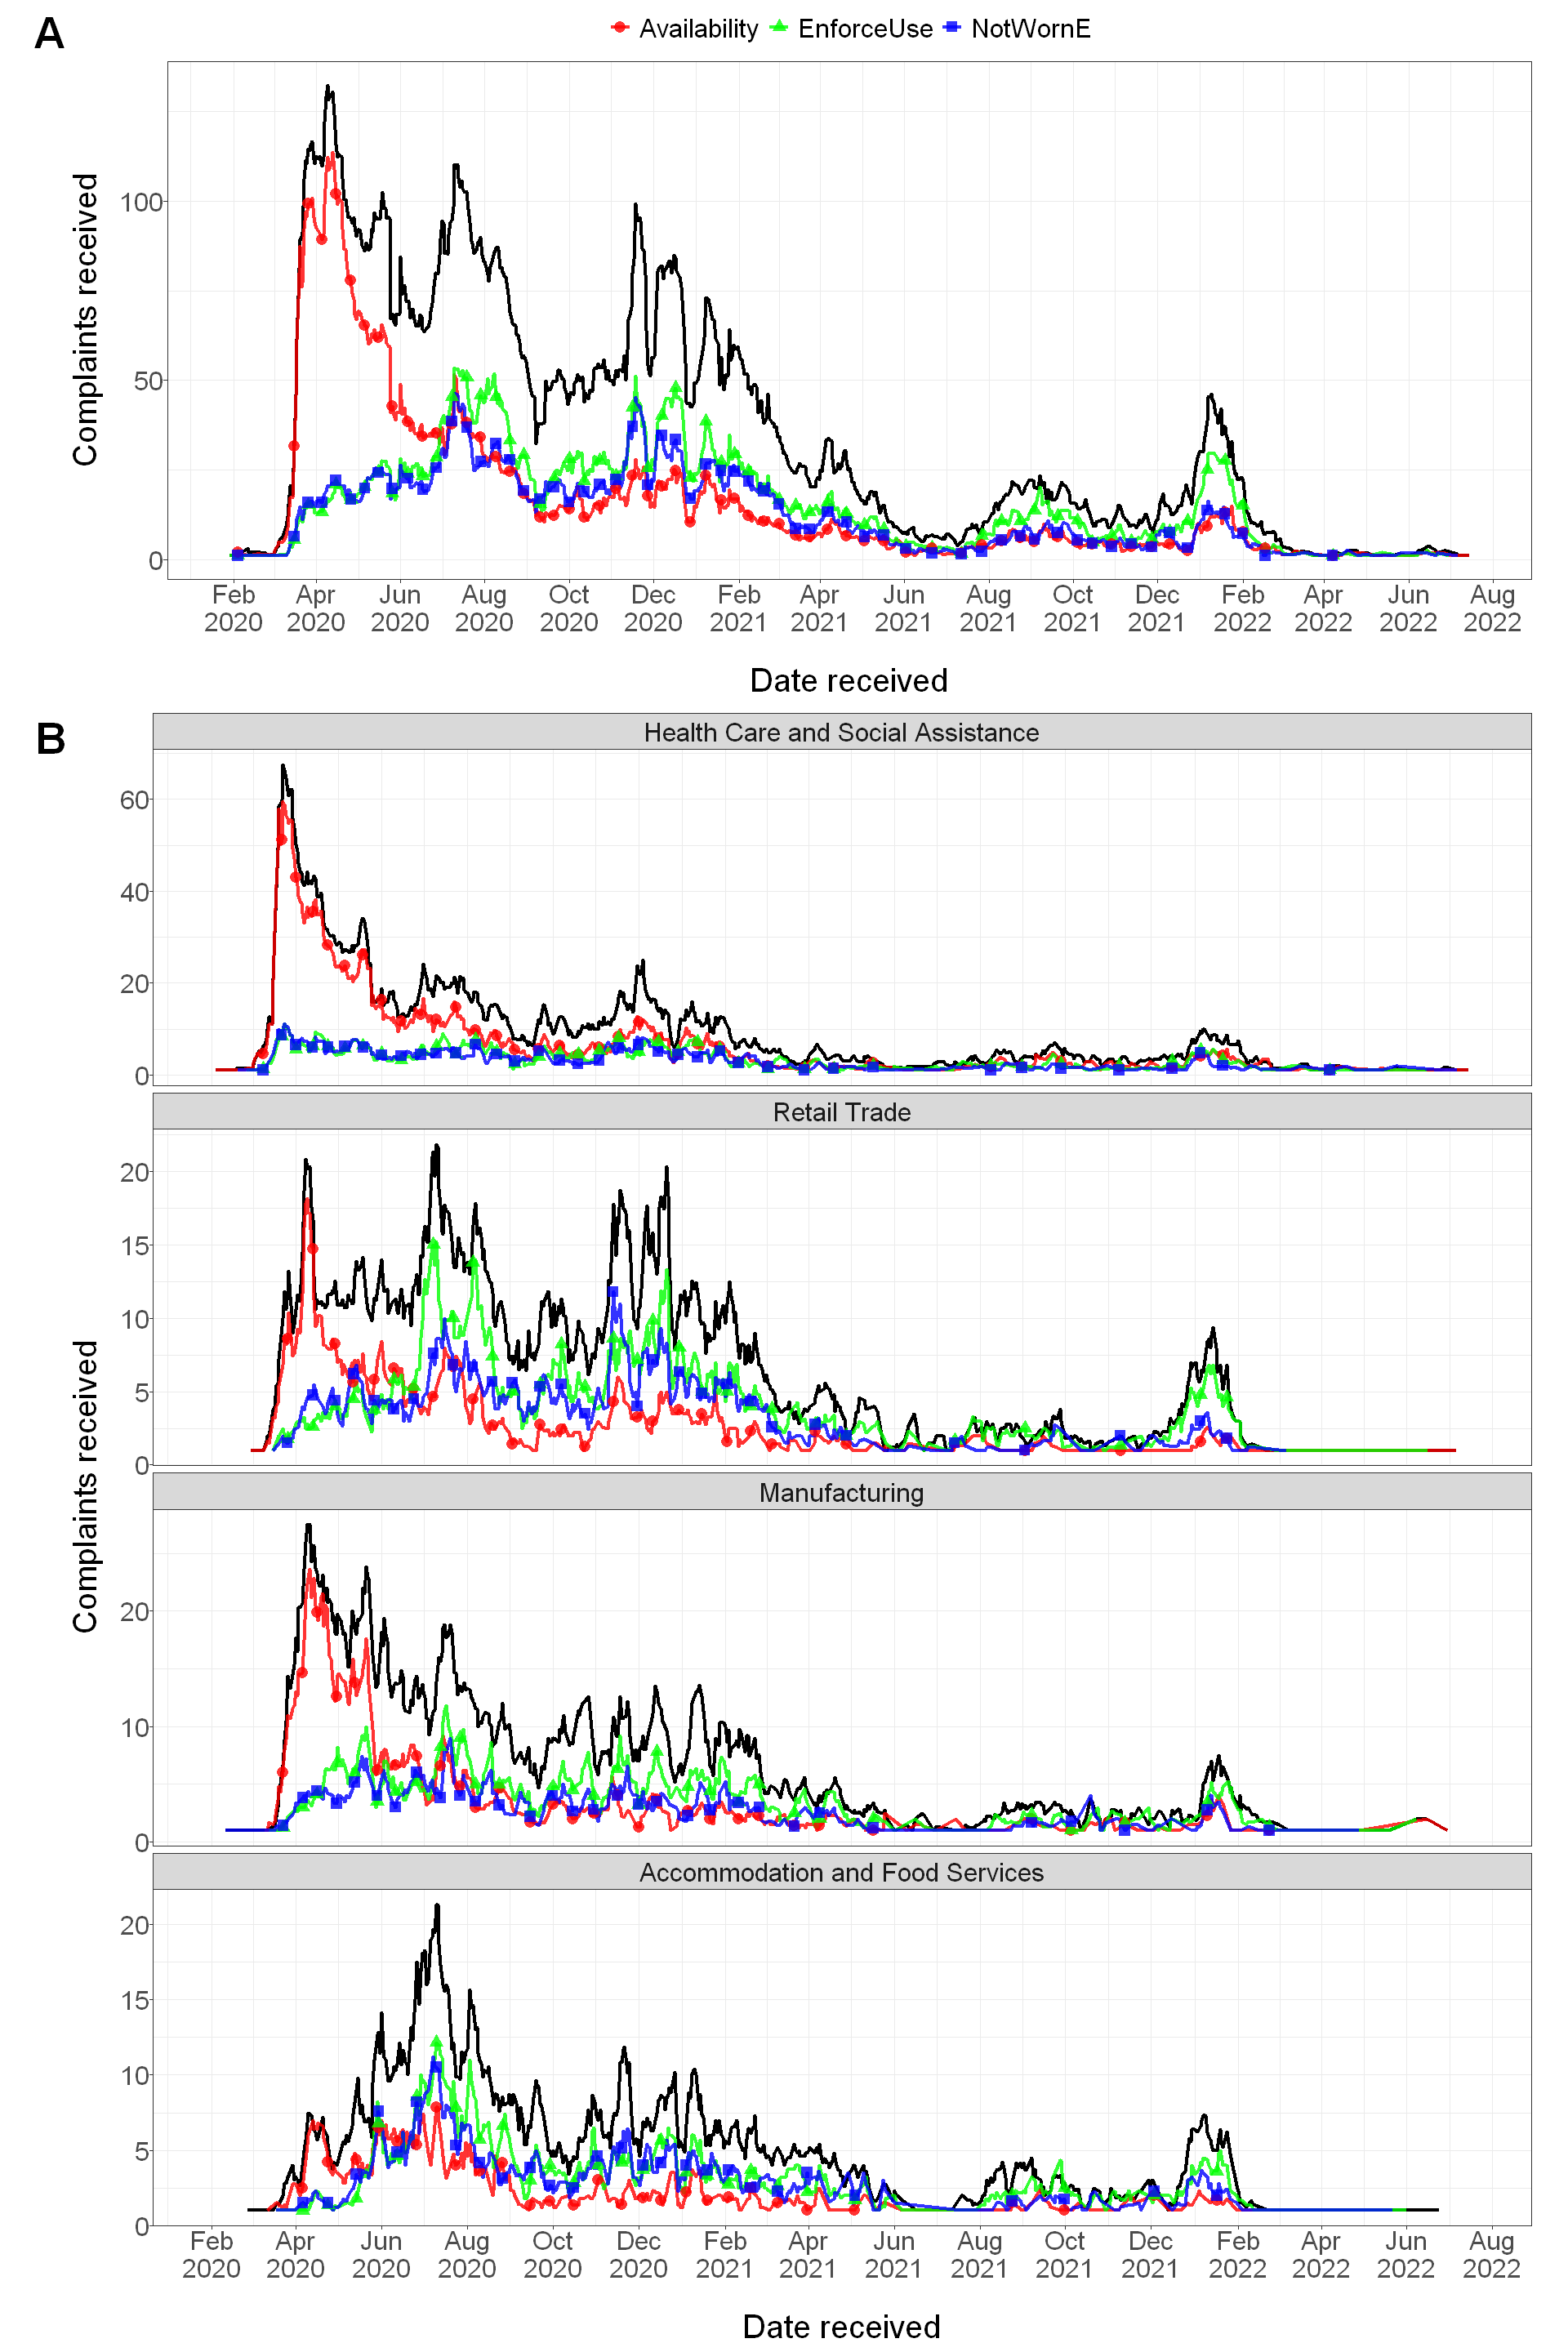

In [15]:
options(repr.plot.width=16, repr.plot.height=24)

panel = ggdraw() +
    draw_plot(complaint_volume_ma7_concerns, x = 0.03, y = 0.7, width = 0.99, height = 0.30, scale = 1) +
    draw_plot(complaint_volume_sectors_concerns, x = 0.03, y = 0.0, width = 0.99, height = 0.70, scale = 1) +
    draw_plot_label(label = c("A", "B"), size = 32, x = c(0, 0), y = c(1, 0.7)) +
    theme(plot.margin = unit(c(t=0, r=3, b=0, l=1), 'lines'))
panel

In [16]:
options(repr.plot.width=16, repr.plot.height=8)
complaint_volume_ma7_concerns_grey = complaint_volume_ma7_concerns + scale_color_manual(values = c("#585858", "#BFBFBF", "#727272"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [17]:
options(repr.plot.width=16, repr.plot.height=18)
complaint_volume_sectors_concerns_grey = complaint_volume_sectors_concerns + scale_color_manual(values = c("#585858", "#BFBFBF", "#727272"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [18]:
options(repr.plot.width=16, repr.plot.height=24)
panel_grey = ggdraw() +
    draw_plot(complaint_volume_ma7_concerns_grey, x = 0.03, y = 0.7, width = 0.99, height = 0.30, scale = 1) +
    draw_plot(complaint_volume_sectors_concerns_grey, x = 0.03, y = 0.0, width = 0.99, height = 0.70, scale = 1) +
    draw_plot_label(label = c("A", "B"), size = 32, x = c(0, 0), y = c(1, 0.7)) +
    theme(plot.margin = unit(c(t=0, r=3, b=0, l=1), 'lines'))

In [19]:
# Write to file
ggsave(complaint_volume_ma7, file="fig_3.eps", device="eps", width=18, height=8, units="in")
ggsave(complaint_volume_ma7_grey, file="fig_3_grey.eps", device="eps", width=18, height=8, units="in")
ggsave(complaint_volume_ma7_concerns, file="fig_4a.eps", device="eps", width=16, height=8, units="in")
ggsave(complaint_volume_sectors_concerns, file="fig_4b.eps", device="eps", width=16, height=18, units="in")
ggsave(panel, file="fig_4.eps", device="eps", width=16, height=24, units="in")
ggsave(panel_grey, file="fig_4_grey.eps", device="eps", width=16, height=24, units="in")

Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
"semi-transparency is not supported on this device: reported only once per page"
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
"semi-transparency is not supported on this device: reported only once per page"
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
"semi-transparency is not supported on this device: reported only once per page"
Warning message in grid.Call.graphics(C_lines, x$x, x$y, index, x$arrow):
"semi-transparency is not supported on this device: reported only once per page"
